In [1]:
import pandas as pd 
pd.options.display.max_columns = 100
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pylab as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg' 
import seaborn as sns
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

In [2]:
PATH_TO_GLOBAL = 'global-economic-monitor/'

### CPI / consumer price index / индекс потребительских цен / индекс инфляции
Гипотетически, инфляция приводит к росту курса доллара к рублю.

In [3]:
core_cpi_not_seas = pd.read_excel(f'{PATH_TO_GLOBAL}Core CPI, not seas. adj..xlsx')
core_cpi_seas = pd.read_excel(f'{PATH_TO_GLOBAL}Core CPI, seas. adj..xlsx')
cpi_price_median = pd.read_excel(f'{PATH_TO_GLOBAL}CPI Price, % y-o-y, median weighted, seas. adj..xlsx')
cpi_price_seas = pd.read_excel(f'{PATH_TO_GLOBAL}CPI Price, % y-o-y, seas. adj..xlsx')
cpi_price_not_seas = pd.read_excel(f'{PATH_TO_GLOBAL}CPI Price, not seas. adj..xlsx')
cpi_price_seas_adj = pd.read_excel(f'{PATH_TO_GLOBAL}CPI Price, seas. adj..xlsx')

In [4]:
def get_cpi(country):
    cpi = pd.DataFrame({
        'core_cpi_not_seas': core_cpi_not_seas[core_cpi_not_seas['Unnamed: 0'] > 2011][country].values,
        'core_cpi_seas': core_cpi_seas[core_cpi_seas['Unnamed: 0'] > 2011][country].values,
        'cpi_price_seas': cpi_price_seas[cpi_price_seas['Unnamed: 0'] > 2011][country].values,
        'cpi_price_not_seas': cpi_price_not_seas[cpi_price_not_seas['Unnamed: 0'] > 2011][country].values,
        'cpi_price_seas_adj': cpi_price_seas_adj[cpi_price_seas_adj['Unnamed: 0'] > 2011][country].values},
                         index = np.arange(2012, 2020))
    return cpi

In [5]:
cpi_russia = get_cpi('Russian Federation')
cpi_russia

,core_cpi_not_seas,core_cpi_seas,cpi_price_seas,cpi_price_not_seas,cpi_price_seas_adj
2012,116.4103,116.6156,5.095844,117.5778,117.8470
2013,122.9615,123.2018,6.764415,125.5187,125.8186
2014,132.2949,132.5107,7.832038,135.3386,135.6728
2015,153.8333,154.1100,15.509780,156.3626,156.7154
2016,165.3205,165.5927,7.029022,167.3743,167.7309
2017,171.1026,171.3841,3.678790,173.5393,173.9014
2018,175.3974,175.6908,2.892110,178.5343,178.9308
2019,181.0385,181.0865,3.655793,185.3438,185.4721


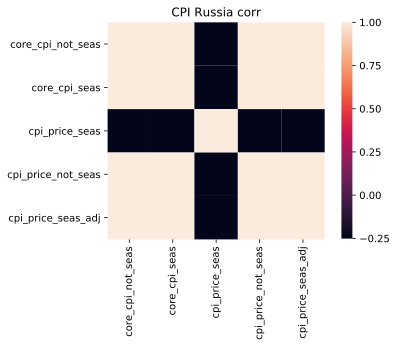

In [6]:
sns.heatmap(cpi_russia.corr(), square=True).set_title('CPI Russia corr');

Есть зависимость между `core_cpi_not_seas`, `core_cpi_seas`, `cpi_price_not_seas` и `cpi_price_seas_adj` (общий тренд инфляции, во всяком случае, виден), т.е. можно для исследований взять среднее между `core_cpi_not_seas` и `core_cpi_seas`.

In [7]:
cpi_russia['core_cpi_mean'] = cpi_russia[['core_cpi_not_seas', 'core_cpi_seas']].mean(axis=1)

In [8]:
russian_data = pd.DataFrame(cpi_russia['core_cpi_mean'])

### EMBI / Emerging Market Bond Index / индекс облигаций развивающихся рынков
Определяет привлекательность инвестиций в высокодоходные гособлигации развивающихся рынков. Инвестиции в такие облигации оказывают позитивное влияние на экономику страны и, следовательно, на курс валюты.

In [9]:
bond_index = pd.read_excel(f'{PATH_TO_GLOBAL}Emerging Market Bond Index (JPM Total Return Index).xlsx')

In [10]:
russian_data['bond_index'] = bond_index['Russian Federation'][-8:].values

In [11]:
# Курс валют. Скорее всего, поведение курса на московской бирже будет коррелировать с этими данными
exchange_rate_new = pd.read_excel(f'{PATH_TO_GLOBAL}Exchange rate, new LCU per USD extended backward, period average.xlsx')
exchange_rate_old = pd.read_excel(f'{PATH_TO_GLOBAL}Exchange rate, old LCU per USD extended forward, period average.xlsx')
# Номинальный эффективный курс
nominal_effective_exchange_rate = pd.read_excel(f'{PATH_TO_GLOBAL}Nominal Effecive Exchange Rate.xlsx')
# Официальный курс. И с этими данными тоже.
off_exchange_rate = pd.read_excel(f'{PATH_TO_GLOBAL}Official exchange rate, LCU per USD, period average.xlsx')
# Реальный эффективный курс
real_effective_exchange_rate = pd.read_excel(f'{PATH_TO_GLOBAL}Real Effective Exchange Rate.xlsx')

In [12]:
# Данные совпадают, можно взять любые
exchange_rate_new['Russian Federation'].values == exchange_rate_old['Russian Federation'].values

array([False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [13]:
russian_data['exchange_rate_average'] = exchange_rate_new['Russian Federation'][-8:].values
russian_data['nominal_effective_exchange_rate'] = nominal_effective_exchange_rate['Russian Federation'][-8:].values
russian_data['off_exchange_rate'] = off_exchange_rate['Russian Federation'][-8:].values
russian_data['real_effective_exchange_rate'] = real_effective_exchange_rate['Russian Federation'][-8:].values

In [14]:
russian_data['off_exchange_rate'] == russian_data['exchange_rate_average']

2012    True
2013    True
2014    True
2015    True
2016    True
2017    True
2018    True
2019    True
dtype: bool

In [15]:
russian_data.drop('exchange_rate_average', axis=1, inplace=True)

### Экспорт
Объем экспорта и его изменение может указывать на экономическое состояние страны  
Если страна что-то производит и продает (или покупает и перепродает), это позитивно сказывается на экономике. Если страна продает больше, чем покупает, это сказывается еще позитивнее.

In [16]:
export_merch_customs_const_2010_not_seas = pd.read_excel(f'{PATH_TO_GLOBAL}Exports Merchandise, Customs, constant 2010 US$, millions, not seas. adj..xlsx')
export_merch_customs_const_2010_seas = pd.read_excel(f'{PATH_TO_GLOBAL}Exports Merchandise, Customs, constant 2010 US$, millions, seas. adj..xlsx')
export_merch_customs_current_not_seas = pd.read_excel(f'{PATH_TO_GLOBAL}Exports Merchandise, Customs, current US$, millions, not seas. adj..xlsx')
export_merch_customs_current_seas = pd.read_excel(f'{PATH_TO_GLOBAL}Exports Merchandise, Customs, current US$, millions, seas. adj..xlsx')
export_merch_customs_price_not_seas = pd.read_excel(f'{PATH_TO_GLOBAL}Exports Merchandise, Customs, Price, US$, not seas. adj..xlsx')
export_merch_customs_price_seas = pd.read_excel(f'{PATH_TO_GLOBAL}Exports Merchandise, Customs, Price, US$, seas. adj..xlsx')

In [17]:
def get_export(country):
    export = pd.DataFrame({
        'export_merch_customs_const_2010_not_seas': export_merch_customs_const_2010_not_seas[export_merch_customs_const_2010_not_seas['Unnamed: 0'] > 2011][country].values,
        'export_merch_customs_const_2010_seas': export_merch_customs_const_2010_seas[export_merch_customs_const_2010_seas['Unnamed: 0'] > 2011][country].values,
        'export_merch_customs_current_not_seas': export_merch_customs_current_not_seas[export_merch_customs_current_not_seas['Unnamed: 0'] > 2011][country].values,
        'export_merch_customs_current_seas': export_merch_customs_current_seas[export_merch_customs_current_seas['Unnamed: 0'] > 2011][country].values,
        'export_merch_customs_price_not_seas': export_merch_customs_price_not_seas[export_merch_customs_price_not_seas['Unnamed: 0'] > 2011][country].values,
        'export_merch_customs_price_seas': export_merch_customs_price_seas[export_merch_customs_price_seas['Unnamed: 0'] > 2011][country].values},
                         index = np.arange(2012, 2020))
    return export

In [18]:
export_russia = get_export('Russian Federation')
export_russia.dropna(axis=0, inplace=True)

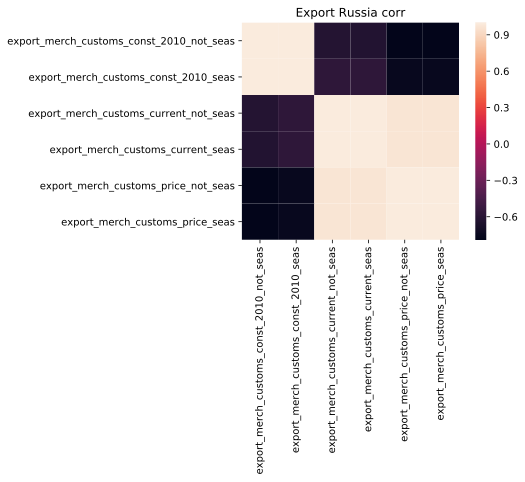

In [19]:
sns.heatmap(export_russia.corr(), square=True).set_title('Export Russia corr');

Такая же картина, что и в случае с инфляцией.

In [20]:
russian_data['export_current_mean'] =  export_russia[['export_merch_customs_current_not_seas', 
                                                      'export_merch_customs_current_seas']].mean(axis=1)

### Золотовалютные резервы
То, в чем хранят средства и на чем зарабатывает ЦБ. При грамотных вложениях приносит прибыль, улучшая экономическое состояние.

In [21]:
foreign_reserves = pd.read_excel(f'{PATH_TO_GLOBAL}Foreign Reserves, Months Import Cover, Goods.xlsx')
total_reserves = pd.read_excel(f'{PATH_TO_GLOBAL}Total Reserves.xlsx')

In [22]:
russian_data['foreign_reserves'] = foreign_reserves['Russian Federation'].values[-8:]
russian_data['total_reserves'] = total_reserves['Russian Federation'][-8:].values

### Gross Domestic Product / валовой внутренний продукт / ВВП
ВВП отражает состояние экономики и производства страны. Однако, нужно большее внимание уделить ВВП, выраженному в USD и отношению номинального ВВП к реальному (дает более полную картину). 

In [23]:
gdp_const_2010_lcu_seas = pd.read_excel(f'{PATH_TO_GLOBAL}GDP at market prices, constant 2010 LCU, millions, seas. adj..xlsx')
gdp_const_2010_us_seas = pd.read_excel(f'{PATH_TO_GLOBAL}GDP at market prices, constant 2010 US$, millions, seas. adj..xlsx')
gdp_current_lcu_seas = pd.read_excel(f'{PATH_TO_GLOBAL}GDP at market prices, current LCU, millions, seas. adj..xlsx')
gdp_current_us_seas = pd.read_excel(f'{PATH_TO_GLOBAL}GDP at market prices, current US$, millions, seas. adj..xlsx')
gdp_deflator = pd.read_excel(f'{PATH_TO_GLOBAL}GDP Deflator at Market Prices, LCU.xlsx')

In [24]:
# Оставим только значения с 2012 по 2019
gdp_deflator = gdp_deflator.iloc[-30:, :]

In [25]:
def get_gdp(country):
    deflator = []
    for i in range(2012, 2020):
        deflator.append(gdp_deflator[gdp_deflator['Unnamed: 0'].str.contains(str(i))][country].mean())
    gdp = pd.DataFrame({
        'gdp_const_2010_lcu_seas': gdp_const_2010_lcu_seas[gdp_const_2010_lcu_seas['Unnamed: 0'] > 2011][country].values,
        'gdp_const_2010_us_seas': gdp_const_2010_us_seas[gdp_const_2010_us_seas['Unnamed: 0'] > 2011][country].values,
        'gdp_current_lcu_seas': gdp_current_lcu_seas[gdp_current_lcu_seas['Unnamed: 0'] > 2011][country].values,
        'gdp_current_us_seas': gdp_current_us_seas[gdp_current_us_seas['Unnamed: 0'] > 2011][country].values,
        'gdp_deflator_mean': deflator},
         index = np.arange(2012, 2020))
    return gdp

In [26]:
gdp_russia = get_gdp('Russian Federation')
gdp_usa = get_gdp('United States')
gdp_russia.dropna(inplace=True)
gdp_usa.drop(index=2019, inplace=True)

In [27]:
gdp_russia

,gdp_const_2010_lcu_seas,gdp_const_2010_us_seas,gdp_current_lcu_seas,gdp_current_us_seas,gdp_deflator_mean
2012,62282200.0,1709649.0,67692971.0,2179980.0,1.086799
2013,63490000.0,1742803.0,72621929.0,2280211.0,1.143752
2014,64219300.0,1762822.0,78869898.0,2074535.0,1.228217
2015,62491600.0,1715397.0,82951483.0,1361324.0,1.327573
2016,62190800.0,1707140.0,85864268.0,1287859.0,1.380642
2017,63165486.0,1733895.0,92010500.0,1578058.0,1.456780
2018,64573695.0,1772550.0,104000000.0,1652215.0,1.604975


In [28]:
gdp_usa

,gdp_const_2010_lcu_seas,gdp_const_2010_us_seas,gdp_current_lcu_seas,gdp_current_us_seas,gdp_deflator_mean
2012,16197100.0,15468319.0,16197100.0,16197100.0,0.999988
2013,16495400.0,15753197.0,16784900.0,16784900.0,1.017515
2014,16899800.0,16139401.0,17521800.0,17521800.0,1.036747
2015,17386800.0,16604489.0,18219300.0,18219300.0,1.047863
2016,17659300.0,16864728.0,18707200.0,18707200.0,1.059307
2017,18050800.0,17238612.0,19485500.0,19485500.0,1.079439
2018,18566500.0,17731109.0,20494200.0,20494200.0,1.103767


Text(0.5, 1.0, 'GDP Russia corr')

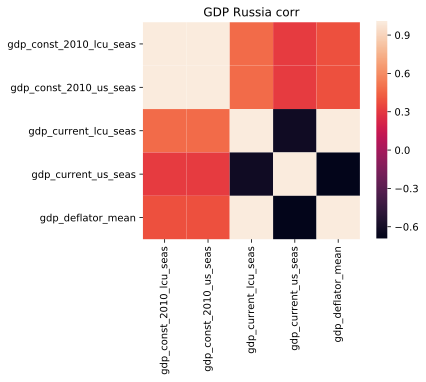

In [29]:
sns.heatmap(gdp_russia.corr(), square=True).set_title('GDP Russia corr')

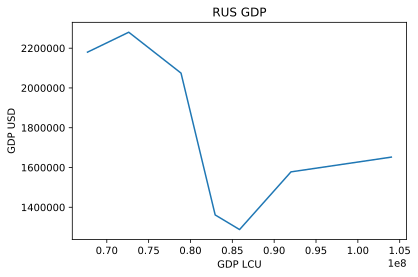

In [30]:
plt.plot(gdp_russia['gdp_current_lcu_seas'].values, gdp_russia['gdp_current_us_seas'].values)
plt.xlabel('GDP LCU')
plt.ylabel('GDP USD')
plt.title('RUS GDP')
plt.show();

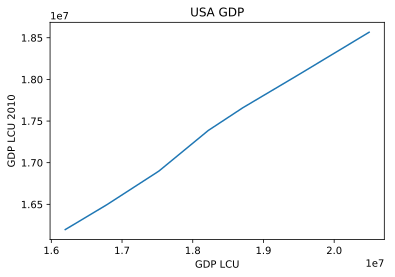

In [31]:
plt.plot(gdp_usa['gdp_current_lcu_seas'].values, gdp_usa['gdp_const_2010_lcu_seas'].values)
plt.xlabel('GDP LCU')
plt.ylabel('GDP LCU 2010')
plt.title('USA GDP')
plt.show();

Видно, что хоть ВВП в рублях стабильно растет, но ВВП в USD зачастую падает. Но тут скорее на это влияет курс рубля, а не наоборот  
Хотя, в последние годы ВВП растет и в рублях, и в долларах  
ВВП относительно цен 2010 года вообще стоит на месте, т.е. экономика в стагнации, а отношение номинального ВВП к реальному уже превышает 1.6  
Все это говорит о том, что рост ВВП РФ в рублях обусловлен лишь повышением цен и не отражает реального положения вещей  
В это время ВВП США (для сравнения) показывает стабильный рост и дефлятор держится в районе 1.1

In [32]:
russian_data['gdp_current_lcu_seas'] = gdp_russia['gdp_current_lcu_seas']
russian_data['gdp_current_us_seas'] = gdp_russia['gdp_current_us_seas']
russian_data['gdp_deflator_mean'] = gdp_russia['gdp_deflator_mean']

### Импорт
Само по себе изменение импорта ни о чем не говорит (разве что снижение говорит о политике импортозамещения), будет использоваться в связке с экспортом.

In [33]:
import_merch_const_2010_not_seas = pd.read_excel(f'{PATH_TO_GLOBAL}Imports Merchandise, Customs, constant 2010 US$, millions, not seas. adj..xlsx')
import_merch_const_2010_seas = pd.read_excel(f'{PATH_TO_GLOBAL}Imports Merchandise, Customs, constant 2010 US$, millions, seas. adj..xlsx')
import_merch_current_not_seas = pd.read_excel(f'{PATH_TO_GLOBAL}Imports Merchandise, Customs, current US$, millions, not seas. adj..xlsx')
import_merch_current_seas = pd.read_excel(f'{PATH_TO_GLOBAL}Imports Merchandise, Customs, current US$, millions, seas. adj..xlsx')
import_merch_price_not_seas = pd.read_excel(f'{PATH_TO_GLOBAL}Imports Merchandise, Customs, Price, US$, not seas. adj..xlsx')
import_merch_price_seas = pd.read_excel(f'{PATH_TO_GLOBAL}Imports Merchandise, Customs, Price, US$, seas. adj..xlsx')

In [34]:
def get_import(country):
    import_ = pd.DataFrame({
        'import_merch_const_2010_not_seas': import_merch_const_2010_not_seas[import_merch_const_2010_not_seas['Unnamed: 0'] > 2011][country].values,
        'import_merch_const_2010_seas': import_merch_const_2010_seas[import_merch_const_2010_seas['Unnamed: 0'] > 2011][country].values,
        'import_merch_current_not_seas': import_merch_current_not_seas[import_merch_current_not_seas['Unnamed: 0'] > 2011][country].values,
        'import_merch_current_seas': import_merch_current_seas[import_merch_current_seas['Unnamed: 0'] > 2011][country].values,
        'import_merch_price_not_seas': import_merch_price_not_seas[import_merch_price_not_seas['Unnamed: 0'] > 2011][country].values,
        'import_merch_price_seas': import_merch_price_seas[import_merch_price_seas['Unnamed: 0'] > 2011][country].values},
         index = np.arange(2012, 2020))
    import_.dropna(inplace=True)
    return import_

In [35]:
import_russia = get_import('Russian Federation')

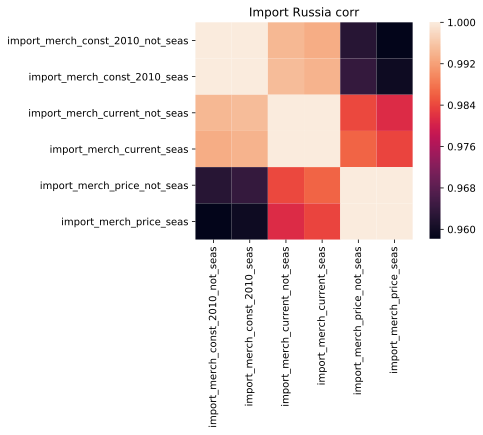

In [36]:
sns.heatmap(import_russia.corr(), square=True).set_title('Import Russia corr');

Видна высокая корреляия между всеми показателями импорта, возьму для наблюдений среднее из `import_merch_current_not_seas` и `import_merch_current_seas`

In [37]:
russian_data['import_current_mean'] = import_russia[['import_merch_current_not_seas', 'import_merch_current_seas']].mean(axis=1)

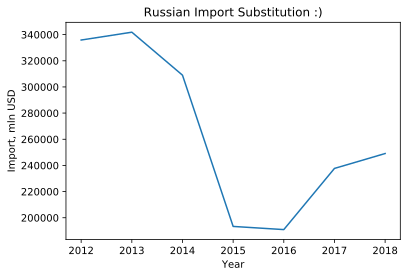

In [38]:
plt.plot(np.arange(2012, 2019), russian_data['import_current_mean'][:-1].values)
plt.xlabel('Year')
plt.ylabel('Import, mln USD')
plt.title('Russian Import Substitution :)')
plt.show();

Посчитаем разницу между экспортом и импортом. Это может быть хорошим признаком  
Если такая разница отрицательна, т.е. импорт превышает экспорт, то это может указывать на неконкурентноспособность экспортных отраслей экономики, что в свою очередь может повлечь за собой обесценивание денежных средств

In [39]:
russian_data['trade_balance'] = russian_data['export_current_mean'] - russian_data['import_current_mean']

На самом деле, у РФ очень высокий торговый баланс, я потом погуглил - 3 место в мире на 2010 год. Видимо, продавали много дорогой нефти. Хотя и сейчас показатели очень высокие. Видимо, стали продавать больше чего-то другого. Кажется, это очень даже хорошо.

### Промышленность
Одна из важнейших составляющих экономики страны.

In [40]:
industrial_prod_const_2010_not_seas = pd.read_excel(f'{PATH_TO_GLOBAL}Industrial Production, constant 2010 US$, not seas. adj..xlsx')
industrial_prod_const_2010_seas = pd.read_excel(f'{PATH_TO_GLOBAL}Industrial Production, constant 2010 US$, seas. adj..xlsx')

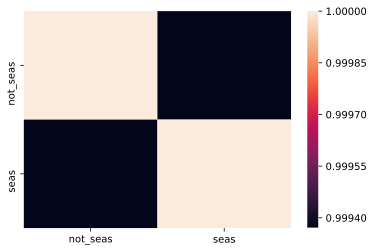

In [41]:
sns.heatmap(pd.DataFrame({'not_seas': industrial_prod_const_2010_not_seas['Russian Federation'].values, 'seas': industrial_prod_const_2010_seas['Russian Federation'].values}).corr());

In [42]:
russian_data['industrial_prod_mean'] = (industrial_prod_const_2010_not_seas['Russian Federation'][-8:]/2 + industrial_prod_const_2010_seas['Russian Federation'][-8:]/2).values

### Рынок ценных бумаг
Не много не понял, что означают эти данные. Общую стоимость российских компаний, размещенных на бирже? Сумму сделок? Общий объем ценных бумаг в обороте? В любом случае, не думаю что это как-то влияет на курс. Скорее, эта цифра зависит от тех же событий, что и курс валюты. То есть с ростом курса доллара будет наблюдаться упадок на рынке ценных бумаг.

In [43]:
stock_markets_lcu = pd.read_excel(f'{PATH_TO_GLOBAL}Stock Markets, LCU.xlsx')
stock_markets_us = pd.read_excel(f'{PATH_TO_GLOBAL}Stock Markets, US$.xlsx')

In [44]:
russian_data['stock_markets_lcu'] = stock_markets_lcu['Russian Federation'][-8:].values
russian_data['stock_markets_us'] = stock_markets_us['Russian Federation'][-8:].values

### Условия торговли
Цена экспорта делится на цену импорта. Если страна продает больше, чем покупает, TOT > 1. Хороший показатель наряду с торговым балансом.

In [45]:
terms_of_trade = pd.read_excel(f'{PATH_TO_GLOBAL}Terms of Trade.xlsx')
terms_of_trade = terms_of_trade.iloc[-100:, :]

In [46]:
tot = []
for i in range(2012, 2020):
    tot.append(terms_of_trade[terms_of_trade['Unnamed: 0'].str.contains(str(i))]['Russian Federation'].mean())
russian_data['terms_of_trade_mean'] = tot

### Уровень безработицы
Высокий и растущий уровень безработицы влечет за собой упадок ВВП и другие проблемы, что будет влиять на курс валют.

In [47]:
unemployment_rate = pd.read_excel(f'{PATH_TO_GLOBAL}Unemployment Rate, seas. adj..xlsx')

In [48]:
russian_data['unemployment_rate'] = unemployment_rate['Russian Federation'][-8:].values

### Данные MOEX

In [49]:
usd_rur = pd.read_csv('USDRUR.csv', sep=';')
usd_rur.head()

,date,rate
0,2012-01-11,31.8729
1,2012-01-12,31.6886
2,2012-01-13,31.6807
3,2012-01-14,31.5830
4,2012-01-17,31.9344


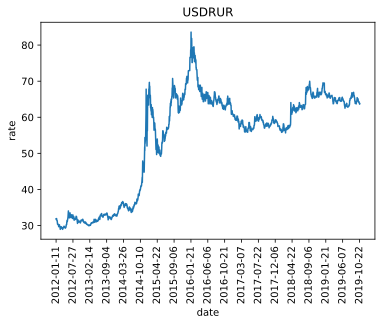

In [50]:
plt.plot(usd_rur['date'].values, usd_rur['rate'].values)
plt.xticks(usd_rur['date'].values[::137],rotation = 90)
plt.xlabel('date')
plt.ylabel('rate')
plt.title("USDRUR")
plt.show()

In [51]:
usd_rur['year'] = usd_rur['date'].apply(lambda x: pd.to_datetime(x).year)

In [52]:
usd_rur_mean = []
for i in range(2012, 2020):
    usd_rur_mean.append(usd_rur[usd_rur['year'] == i]['rate'].mean())

In [53]:
russian_data['moex_mean_exchange_rate'] = usd_rur_mean

### Данные собраны, можно приступать к анализу

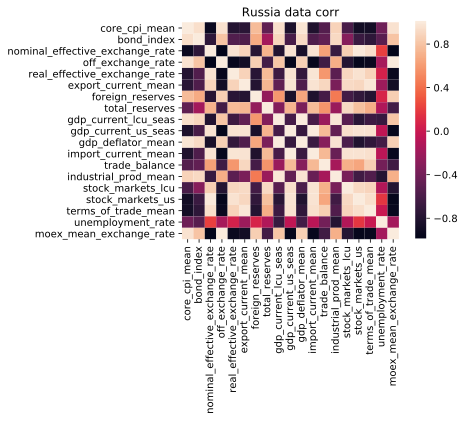

In [54]:
sns.heatmap(russian_data.corr(), square=True).set_title('Russia data corr');

Видно, что курс на бирже коррелирует практически со всеми данными.

Отмасштабируем данные чтобы строить графики в одном масштабе. Значения не так важны, как понимание растет или убывает тот или иной показатель.

In [55]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
russian_data_scaled = pd.DataFrame(min_max_scaler.fit_transform(russian_data), columns=russian_data.columns, index=russian_data.index)

In [56]:
russian_data.reset_index(inplace=True)
russian_data.rename(columns={'index': 'year'}, inplace=True)
russian_data_scaled.reset_index(inplace=True)
russian_data_scaled.rename(columns={'index': 'year'}, inplace=True)

In [57]:
russian_data = russian_data.merge(russian_data_scaled, on='year', how='left', suffixes=['', '_scaled'])

In [58]:
russian_data

,year,core_cpi_mean,bond_index,nominal_effective_exchange_rate,off_exchange_rate,real_effective_exchange_rate,export_current_mean,foreign_reserves,total_reserves,gdp_current_lcu_seas,gdp_current_us_seas,gdp_deflator_mean,import_current_mean,trade_balance,industrial_prod_mean,stock_markets_lcu,stock_markets_us,terms_of_trade_mean,unemployment_rate,moex_mean_exchange_rate,core_cpi_mean_scaled,bond_index_scaled,nominal_effective_exchange_rate_scaled,off_exchange_rate_scaled,real_effective_exchange_rate_scaled,export_current_mean_scaled,foreign_reserves_scaled,total_reserves_scaled,gdp_current_lcu_seas_scaled,gdp_current_us_seas_scaled,gdp_deflator_mean_scaled,import_current_mean_scaled,trade_balance_scaled,industrial_prod_mean_scaled,stock_markets_lcu_scaled,stock_markets_us_scaled,terms_of_trade_mean_scaled,unemployment_rate_scaled,moex_mean_exchange_rate_scaled
0,2012,116.51295,879.5089,103.00510,31.05650,104.40180,527699.30,1.600212,537617.6,67692971.0,2179980.0,1.086799,335868.30,191831.00,5.280000e+11,97.52746,94.01185,1.414217,5.430565,31.074172,0.000000,0.000000,1.000000,0.000000,0.930810,1.000000,0.481909,1.000000,0.000000,0.898997,0.000000,0.960334,0.978561,0.000000,1.000000,1.000000,1.000000,0.816415,0.000000
1,2013,123.08165,909.8544,100.79420,31.86124,106.32120,521851.05,1.488127,509594.8,72621929.0,2280211.0,1.143752,341854.70,179996.35,5.345000e+11,93.94799,88.16642,1.321807,5.481335,31.906305,0.101762,0.105762,0.946621,0.022352,1.000000,0.976285,0.330667,0.834399,0.135758,1.000000,0.109911,1.000000,0.864656,0.120370,0.910479,0.912603,0.851930,0.881288,0.023140
2,2014,132.40280,896.0026,88.21376,38.58106,97.15642,497367.25,1.243070,385459.9,78869898.0,2074535.0,1.228217,308982.00,188385.25,5.470000e+11,78.44005,62.95364,1.273147,5.157411,38.602468,0.246165,0.057485,0.642882,0.209002,0.669632,0.877001,0.000000,0.100823,0.307845,0.792739,0.272915,0.782184,0.945397,0.351852,0.522631,0.535637,0.773963,0.467384,0.209348
3,2015,153.97165,926.0739,65.15824,61.33828,80.05609,341814.75,1.901871,368398.7,82951483.0,1361324.0,1.327573,193361.15,148453.60,5.395000e+11,57.54286,28.53856,0.976513,5.574240,60.968334,0.580309,0.162291,0.086235,0.841108,0.053208,0.246223,0.888951,0.000000,0.420263,0.074031,0.464657,0.016074,0.561064,0.212963,0.000000,0.021084,0.298664,1.000000,0.831300
4,2016,165.45660,1049.7690,61.58649,67.05876,78.58005,281095.10,1.984169,377741.3,85864268.0,1287859.0,1.380642,190935.30,90159.80,5.535000e+11,60.20247,27.12839,0.790116,5.524072,67.034895,0.758234,0.593400,0.000000,1.000000,0.000000,0.000000,1.000000,0.055210,0.500490,0.000000,0.567073,0.000000,0.000000,0.472222,0.066516,0.000000,0.000000,0.935896,1.000000
5,2017,171.24335,1116.1870,70.45271,58.31053,92.43135,353042.30,1.823620,432742.2,92010500.0,1578058.0,1.456780,237712.25,115330.05,5.655000e+11,72.53826,37.11262,0.894400,5.199572,58.352940,0.847882,0.824883,0.214064,0.757009,0.499305,0.291752,0.783364,0.380238,0.669775,0.292436,0.714006,0.309947,0.242258,0.694444,0.375029,0.149278,0.167095,0.521257,0.758571
6,2018,175.54410,1110.3770,65.28156,62.84197,84.54156,443153.90,1.877217,468495.0,104000000.0,1652215.0,1.604975,249095.45,194058.45,5.820000e+11,76.65260,36.66968,1.053091,4.791633,62.707772,0.914509,0.804634,0.089213,0.882874,0.214898,0.657162,0.855685,0.591520,1.000000,0.367164,1.000000,0.385372,1.000000,1.000000,0.477928,0.142655,0.421366,0.000000,0.879671
7,2019,181.06250,1166.4320,64.21584,65.51285,85.53008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79.49542,36.20725,NaN,NaN,65.030842,1.000000,1.000000,0.063482,0.957061,0.250531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.549025,0.135741,NaN,NaN,0.944271


In [59]:
def show_plot(columns, labels, title, y_label=''):
    for index, column in enumerate(columns):
        plt.plot(russian_data['year'], russian_data[column], label=labels[index])
    plt.xlabel('Year')
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.show();

#### Проанализируем как зависит курс на бирже от данных`nominal_effective_exchange_rate` `off_exchange_rate` и `real_effective_exchange_rate`

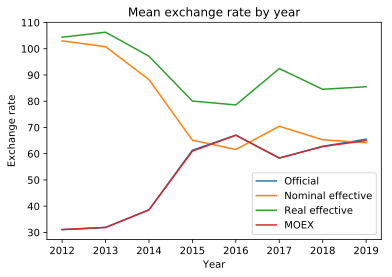

In [60]:
show_plot(['off_exchange_rate', 'nominal_effective_exchange_rate', 
           'real_effective_exchange_rate', 'moex_mean_exchange_rate'],
          ['Official', 'Nominal effective', 'Real effective', 'MOEX'],
          'Mean exchange rate by year',
          'Exchange rate')

По графику видно, что официальные данные практически совпадают с курсом на бирже. 
Также видно, что до 2014 года рубль был сильно переоценен, эффективный курс доллара к рублю составлял более 90.    
Гипотеза подтверждается: курс рубля на бирже до 2014 года зависил от официального курса рубля, устанавливаемого ЦБ. После событий 2014 года и перехода к плавающему курсу, стоимость рубля приблизилась к эффективным значениям, а курс на бирже по прежнему коррелирует с официальными значениями.

#### Как зависит курс от уровня инфляции

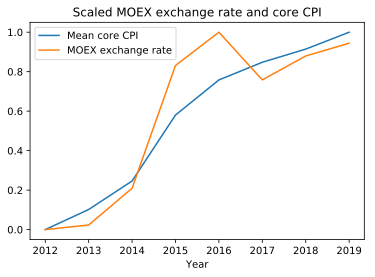

In [61]:
show_plot(['core_cpi_mean_scaled', 'moex_mean_exchange_rate_scaled'],
          ['Mean core CPI', 'MOEX exchange rate'],
          'Scaled MOEX exchange rate and core CPI')

Как и ожидалось, высокий уровень инфляции влечет за собой рост курса валюты.

#### Как зависит курс от индекса облигаций развивающихся рынков

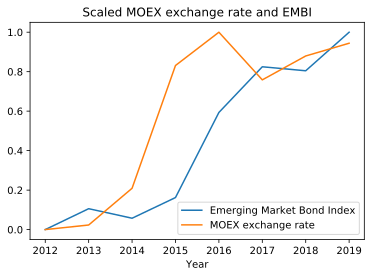

In [62]:
show_plot(['bond_index_scaled', 'moex_mean_exchange_rate_scaled'],
          ['Emerging Market Bond Index', 'MOEX exchange rate'],
          'Scaled MOEX exchange rate and EMBI')

Вполне закономерно, что с ростом риска гособлигации страны становятся менее привлекательными для инвесторов, что оказывает свое влияние на экономику страны и курс валюты.

#### Зависимость от экспорта, импорта, торгового баланса и terms of trade

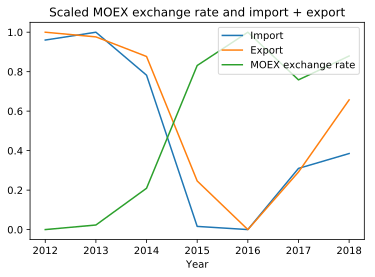

In [63]:
russian_data.dropna(inplace=True)
show_plot(['import_current_mean_scaled', 'export_current_mean_scaled' ,'moex_mean_exchange_rate_scaled'],
          ['Import', 'Export', 'MOEX exchange rate'],
          'Scaled MOEX exchange rate and import + export')

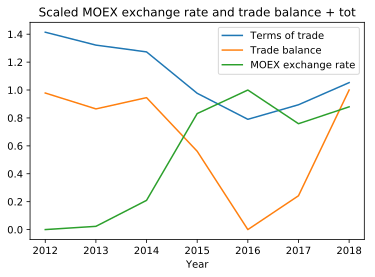

In [64]:
show_plot(['terms_of_trade_mean', 'trade_balance_scaled' ,'moex_mean_exchange_rate_scaled'],
          ['Terms of trade', 'Trade balance', 'MOEX exchange rate'],
          'Scaled MOEX exchange rate and trade balance + tot')

Из графиков видно, что в 2014 резко снизился как экспорт, так и импорт. Однако, просевшие показатели `terms of trade` и `trade balance` указывают на то, что экспорт просел сильнее.  
Такое снижение экпортируемой продукции влечет за собой проблемы в экономике и рост курса.

#### Зависимость от запасов

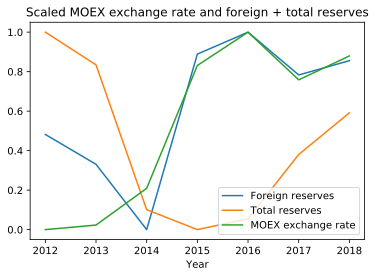

In [65]:
show_plot(['foreign_reserves_scaled', 'total_reserves_scaled' ,'moex_mean_exchange_rate_scaled'],
          ['Foreign reserves', 'Total reserves', 'MOEX exchange rate'],
          'Scaled MOEX exchange rate and foreign + total reserves')

Видно, что с уменьшением размера общих резервов курс начал расти. Хотя, возможно, наоборот: с ростом курса умеьшился размер запасов в пересчете на USD.
Видимо, чтобы как-то стабилизировать это, ЦБ начал делать больше запасов в иностранной валюте, что также видно из графика.

#### Зависимость от ВВП

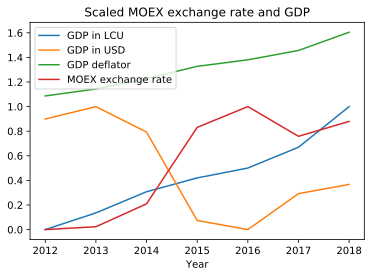

In [66]:
show_plot(['gdp_current_lcu_seas_scaled', 'gdp_current_us_seas_scaled', 'gdp_deflator_mean' ,'moex_mean_exchange_rate_scaled'],
          ['GDP in LCU', 'GDP in USD', 'GDP deflator', 'MOEX exchange rate'],
          'Scaled MOEX exchange rate and GDP')

Тут как и предполагалось: несмотря на рост ВВП в рублях, ВВП в долларах падает, отношение номинального ВВП к реальному растет, курс растет.

#### Промышленость

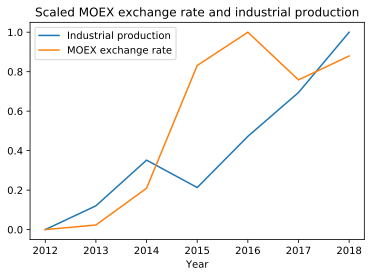

In [67]:
show_plot(['industrial_prod_mean_scaled', 'moex_mean_exchange_rate_scaled'],
          ['Industrial production', 'MOEX exchange rate'],
          'Scaled MOEX exchange rate and industrial production')

Промышленность растет, однако держим в уме снижение экспорта. Возможно, в будущем этот рост будет иметь положительное влияние на позиции рубля.

#### Рынок ценных бумаг

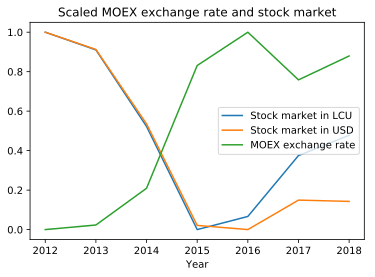

In [68]:
show_plot(['stock_markets_lcu_scaled', 'stock_markets_us_scaled' ,'moex_mean_exchange_rate_scaled'],
          ['Stock market in LCU', 'Stock market in USD', 'MOEX exchange rate'],
          'Scaled MOEX exchange rate and stock market')

Как и предполагалось, данные значения перекликаются с поведением курса доллара. Не думаю, что одно связано с другим, скорее они просто оказались под влиянием одних и тех же событий.

#### Уровень безработицы

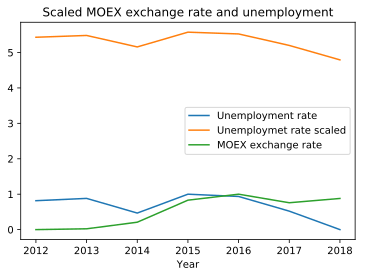

In [69]:
show_plot(['unemployment_rate_scaled', 'unemployment_rate', 'moex_mean_exchange_rate_scaled'],
          ['Unemployment rate', 'Unemploymet rate scaled','MOEX exchange rate'],
          'Scaled MOEX exchange rate and unemployment')

Уровень безработицы держится в районе 5%. Ее увеличение могло бы повлечь за собой экономические проблемы, но пока этого не наблюдается (роста безработицы).

### Заключение    
Я далеко не экономист вполне мог что-то не так понять или интерпретировать. Надеюсь на понимание.  
Получилось исследование влияния экономики на курс доллара к рублю не только на  московской бирже, но и в целом. Хотя, как было выяснено выше, это фактически одно и то же.  
Не были учтены факторы развития других стран, хотя я и заклыдывал такую возможность при получении данных. Но решил, что на курс доллара к рублю в данный момент больше влияет именно ослабление рубля, в то время как доллар стабилен.  
Все выдвинутые гипотезы подтвердились.